# CASSIOPE Data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

Functions to load noise

In [9]:
cdf = pycdf.CDF(r'utility\SPACE_DATA\cassiope.cdf')
B_in = np.array(cdf['B_inboard_CRF']).T
B_out = np.array(cdf['B_outboard_CRF']).T
t = np.array(cdf['Timestamp'])


In [93]:
B = np.array([B_in[:,:100000], B_out[:,:100000]])
t = t[:100000]
B = B - uniform_filter1d(B, size=3000, axis=-1)
B = B[:,:,73000:97000]
t = t[73000:97000]
noise = B[1] - B[0]

In [97]:
print(t.shape)

(0,)


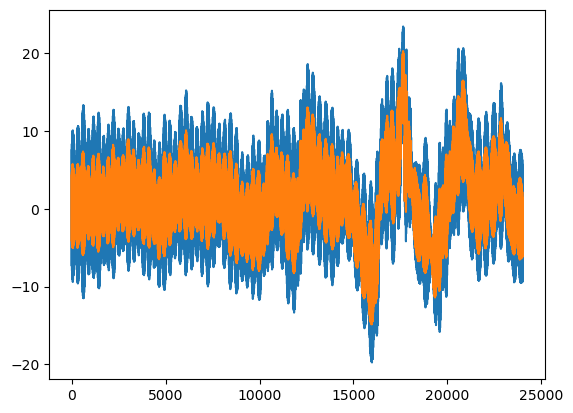

In [98]:
plt.plot(B[0,2])
plt.plot(B[1,2])


Find Coupling Coefficients

In [127]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib

importlib.reload(RAMEN)


RAMEN.fs = 1000/6
RAMEN.weights = np.geomspace(10,.1,B.shape[0])
RAMEN.sspTol = 15
result_ramen = RAMEN.clean(np.flip(np.copy(B[:,2]),axis=0), triaxial=False)
print(pearsonr(result_ramen, noise[2])[0])
print(pearsonr(B[1,2], noise[2])[0])
print(RAMEN.aii)

-0.9987005820922277
-0.5733055568375938
[[1.         1.        ]
 [1.         1.03450979]]


c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\RAMEN.py:112: RuntimeWarning: invalid value encountered in divide
  alpha_ij = np.nanmean(np.abs(B_filtered[0]) / np.abs(B_filtered[i]), axis=-1)


In [113]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = 1000/6
WAICUPV2.uf=10000
WAICUPV2.detrend = True
#WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'ramen'
WAICUPV2.sspTol = 30
result_waicup = WAICUPV2.clean(np.copy(B[:,2]), triaxial=False)
print(pearsonr(result_waicup, noise[2])[0])
print(pearsonr(B[1,2], noise[2])[0])

-0.20196225921645383
-0.5733055568375938


In [115]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = 1000/6
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 30
HOG.gain_method = 'ramen'

result_hog= HOG.clean(np.flip(np.copy(B[:,2]), axis=0), triaxial=False)
print(pearsonr(result_hog, noise[2])[0])
print(pearsonr(B[1,2], noise[2])[0])
print(HOG.aii)

-0.5461629779824306
-0.5733055568375938
[[ 1.          1.        ]
 [ 1.         14.21023146]]


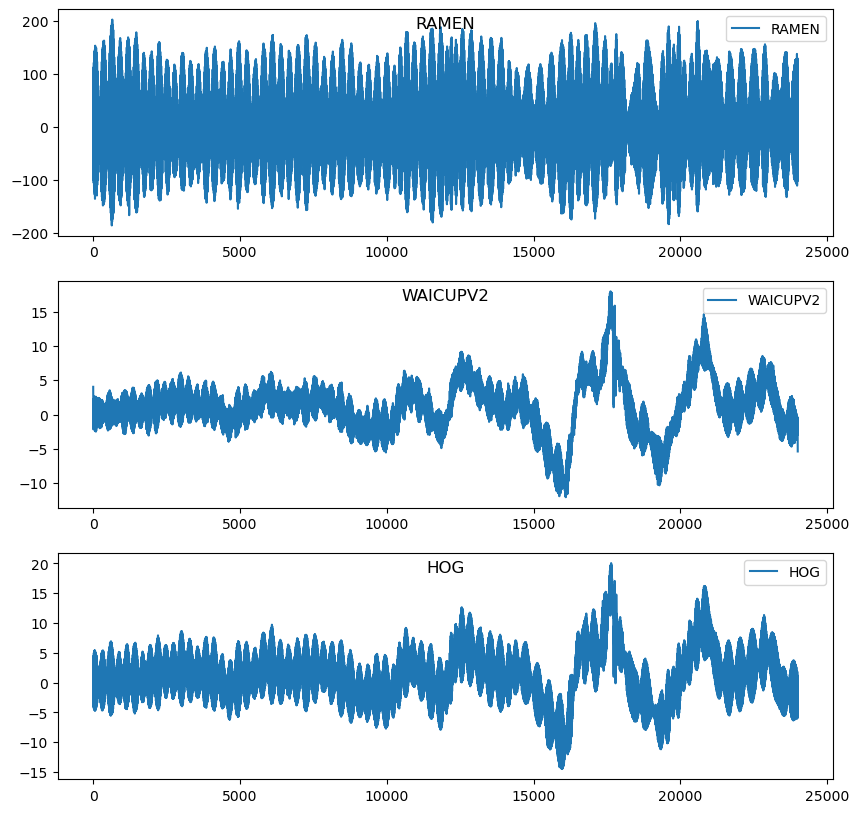

In [128]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(result_ramen, label = 'RAMEN')
axs[0].set_title("RAMEN", y=1.0, pad=-14)
axs[0].legend()
axs[1].plot(result_waicup, label = 'WAICUPV2')
axs[1].set_title('WAICUPV2', y=1.0, pad=-14)
axs[1].legend()
axs[2].plot(result_hog, label = 'HOG')
axs[2].set_title('HOG', y=1.0, pad=-14)
axs[2].legend()


In [ ]:
"Take Continuous Wavelet Transform"
import fcwt
fs_waicup_kplo = 50  # Hz
f0 = 0.0001  # Hz
f1 = 25 / 2  # Hz


# take transform of B_kplo Z-axis
freqs, out = fcwt.cwt(B[2,2], fs_waicup_kplo, f0, f1, fn=300, scaling='log', nthreads=12)
freqs = np.flip(freqs)
